# Example 1: single-trial GLM estimation in a rapid event-related design

### Natural Scenes Dataset core experiment, subj01, nsd01 scan session

---------------------

##### GLMsingle is new tool that provides efficient, scalable, and accurate single-trial fMRI response estimates.

The purpose of this Example 1 notebook is to guide the user through basic
calls to GLMsingle, using a representative, small-scale test dataset (in
this case, an example session from a rapid event-related visual fMRI
dataset - the Natural Scenes Dataset core experiment).

The goal is to examine the effect of GLMsingle on the reliability of
single-trial fMRI response estimates. By default, the tool implements a
set of optimizations that improve upon generic GLM approaches by: (1)
identifying an optimal hemodynamic response function (HRF) at each voxel,
(2) deriving a set of useful GLM nuisance regressors via "GLMdenoise" and
picking an optimal number to include in the final GLM, and (3) applying a
custom amount of ridge regularization at each voxel using an efficient
technique called "fracridge". The output of GLMsingle are GLM betas
reflecting the estimated percent signal change in each voxel in response
to each experimental stimulus or condition being modeled.

Beyond directly improving the reliability of neural responses to repeated
stimuli, these optimized techniques for signal estimation can have a
range of desirable downstream effects such as: improving cross-subject
representational similarity within and between datasets; improving the
single-image decodability of evoked neural patterns via MVPA; and,
decreasing the correlation in spatial patterns observed at neighboring
timepoints in analysis of fMRI GLM outputs. See our video presentation at
V-VSS 2020 for a summary of these phenomena as observed in recent
massive-scale fMRI datasets (the Natural Scenes Dataset and BOLD5000):
https://www.youtube.com/watch?v=yb3Nn7Han8o

**Example 1 contains a full walkthrough of the process of loading an
example dataset and design matrix, estimating neural responses using
GLMsingle, estimating the reliability of responses at each voxel, and
comparing those achieved via GLMsingle to those achieved using a baseline
GLM.** After loading and visualizing formatted fMRI time-series and their
corresponding design matrices, we will describe the default behavior of
GLMsingle and show how to modify hyperparameters if the user desires.
Throughout the notebook we will highlight important metrics and outputs
using figures, print statements, and comments.

Users encountering bugs, unexpected outputs, or other issues regarding
GLMsingle shouldn't hesitate to raise an issue on GitHub:
https://github.com/kendrickkay/GLMsingle/issues


### Import function libraries

In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel as nib

import os
from os.path import join, exists, split
import sys
import time
import urllib.request
import copy
import warnings
from tqdm import tqdm
from pprint import pprint
warnings.filterwarnings('ignore')

import glmsingle
from glmsingle.glmsingle import GLM_single

# note: the fracridge repository is also necessary to run this code
# for example, you could do:
#      git clone https://github.com/nrdg/fracridge.git

### Set paths and download the example dataset

In [4]:
# get path to the directory to which GLMsingle was installed
homedir = split(os.getcwd())[0]

# create directory for saving data
datadir = join(homedir,'examples','data_control')
os.makedirs(datadir,exist_ok=True)

# create directory for saving outputs from example 1
outputdir = join(homedir,'examples','example1outputs')

print(f'directory to save example dataset:\n\t{datadir}\n')
print(f'directory to save example1 outputs:\n\t{outputdir}\n')

directory to save example dataset:
	/Users/gt/Documents/GitHub/GLMsingle/examples/data_control

directory to save example1 outputs:
	/Users/gt/Documents/GitHub/GLMsingle/examples/example1outputs



### Organize BOLD data, design matrices, metadata

In [28]:
UID = '853'
SESSIONS = ['FED_20211008a_3T1_PL2017', 'FED_20211013b_3T1_PL2017']
n_trs = 168

In [29]:
data = []
for s in SESSIONS:
    print(f'Loading data from session {s}')
    for f in sorted(os.listdir(join(datadir, UID, s))):
        print(f)
        file = np.array(nib.load(join(datadir, UID, s, f)).dataobj)
        assert (file.shape[3] == n_trs)
        data.append(file)
        
# get shape of data volume (XYZ) for convenience
xyz = data[0].shape[:3]
xyzt = data[0].shape

# get metadata about stimulus duration and TR
stimdur = 1
tr = 2

Loading data from session FED_20211008a_3T1_PL2017
swr867000-09.nii
swr867000-10.nii
swr867000-11.nii
swr867000-13.nii
swr867000-14.nii
swr867000-15.nii
swr867000-16.nii
swr867000-18.nii
swr867000-19.nii
swr867000-20.nii
Loading data from session FED_20211013b_3T1_PL2017
swr876000-09.nii
swr876000-10.nii
swr876000-11.nii
swr876000-13.nii
swr876000-14.nii
swr876000-15.nii
swr876000-16.nii
swr876000-18.nii
swr876000-19.nii
swr876000-20.nii


In [30]:
len(data)

20

In [31]:
data[0].shape

(91, 109, 91, 168)

In [32]:
design = pd.read_pickle('/Users/gt/Documents/GitHub/GLMsingle/design_matrices/design_matrices_UID-853_SESSION-FED_20211008a_3T1_PL2017-FED_20211013b_3T1_PL2017_FL-control_tr1_20220109.pkl')

In [33]:
len(design)

20

In [34]:
design[0].shape

(168, 333)

In [35]:
assert (len(data) == len(design))

In [36]:
assert(xyzt[-1] == design[0].shape[0])

In [4]:
# variables that will contain bold time-series and design matrices from each run
data = []
design = []

# iterate through each run of data
for r in range(len(X['data'][0])):
    
    # index into struct, append each run's timeseries data to list
    data.append(X['data'][0,r])
    
    # convert each run design matrix from sparse array to full numpy array, append
    design.append(scipy.sparse.csr_matrix.toarray(X['design'][0,r]))
    
# get shape of data volume (XYZ) for convenience
xyz = data[0].shape[:3]
xyzt = data[0].shape

# get metadata about stimulus duration and TR
stimdur = X['stimdur'][0][0]
tr = X['tr'][0][0]

# get visual ROI mask identifying occipital cortex
roi = X['ROI']

In [19]:
f=('/Users/gt/Desktop/swr867000-9.nii')

In [20]:
file=np.array(nib.load(f).dataobj)

In [21]:
file.shape

(91, 109, 91, 168)

### Visualize sample data and design matrix

In [5]:
# data -> consists of several runs of 4D volume files (x,y,z,t)  where
# (t)ime is the 4th dimention. in this example, data consists of only a
# single slice and has been prepared with a TR = 1s

# ROI -> manually defined region in the occipital cortex. it is a binary
# matrix where (x,y,z) = 1 corresponds to the cortical area that responded
# to visual stimuli used in the NSD project.

# design -> each run has a corresponding design matrix where each column
# describes a single condition (conditions are repeated across runs). each
# design matrix is binary with 1 specfing the time (TR) when the stimulus
# is presented on the screen.

# in this NSD scan session, there are a total of 750 trials, in which a
# total of 583 distinct images are shown. (thus, some images were presented
# more than once.) in the design matrix plotted below, there are 583 predictor
# columns/conditions, one per distinct image. notice that the ordering of 
# conditions is pseudo-randomized. note also that in some runs not all images 
# are shown; if a column is empty it simply means that this image is shown 
# in a different run within the session.

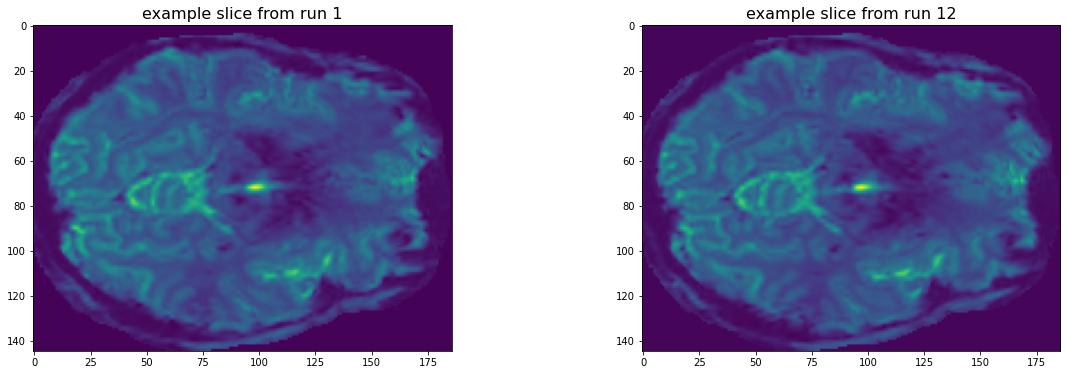

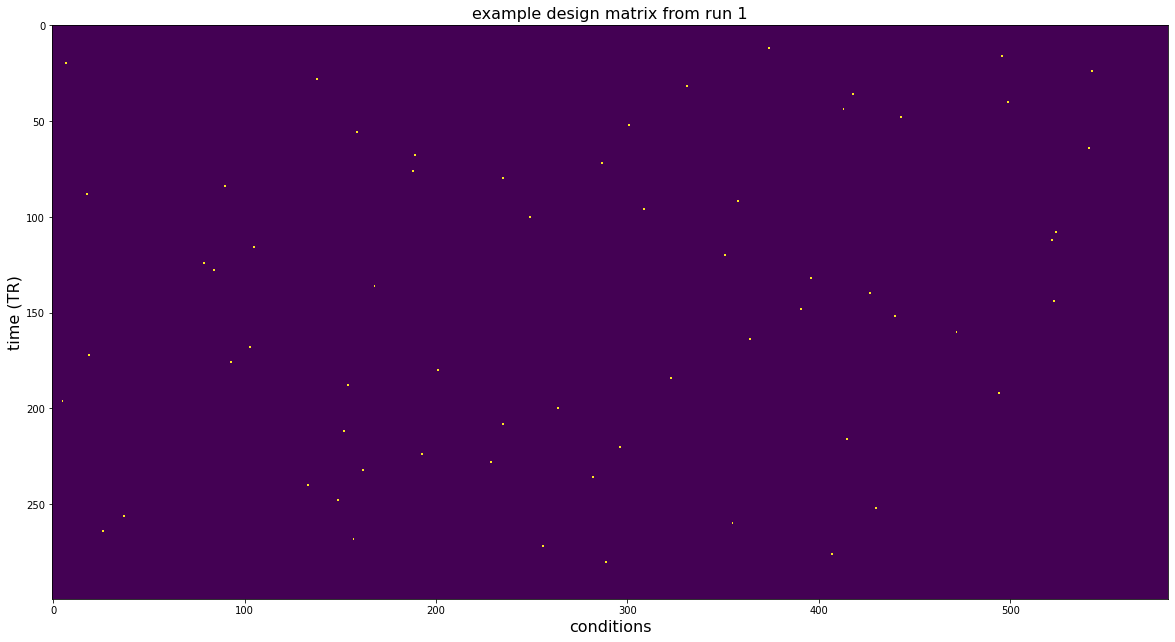

In [6]:
# plot example slice from run 1
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.imshow(data[0][:,:,0,0])
plt.title('example slice from run 1',fontsize=16)
plt.subplot(122)
plt.imshow(data[11][:,:,0,0])
plt.title('example slice from run 12',fontsize=16)

# plot example design matrix from run 1
plt.figure(figsize=(20,20))
plt.imshow(design[0],interpolation='none')
plt.title('example design matrix from run 1',fontsize=16)
plt.xlabel('conditions',fontsize=16)
plt.ylabel('time (TR)',fontsize=16);

In [11]:
# Data is a list of runs. Each run has a 4D matrix
data[0].shape

(145, 186, 1, 300)

In [7]:
len(design)

12

In [9]:
design[0].shape

(300, 583)

In [7]:
# print some relevant metadata
print(f'There are {len(data)} runs in total\n')
print(f'N = {data[0].shape[3]} TRs per run\n')
print(f'The dimensions of the data for each run are: {data[0].shape}\n')
print(f'The stimulus duration is {stimdur} seconds\n')
print(f'XYZ dimensionality is: {data[0].shape[:3]} (one slice only in this example)\n')
print(f'Numeric precision of data is: {type(data[0][0,0,0,0])}\n')
print(f'There are {np.sum(roi)} voxels in the included visual ROI')

There are 12 runs in total

N = 300 TRs per run

The dimensions of the data for each run are: (145, 186, 1, 300)

The stimulus duration is 3 seconds

XYZ dimensionality is: (145, 186, 1) (one slice only in this example)

Numeric precision of data is: <class 'numpy.float32'>

There are 2653 voxels in the included visual ROI


### Run GLMsingle with default parameters to estimate single-trial betas

In [8]:
# outputs and figures will be stored in a folder (you can specify its name
# as the 5th output to GLMsingle). model estimates can be also
# saved to the 'results' variable which is the only output of
# GLMsingle.

# optional parameters below can be assigned to a structure, i.e., opt =
# dict('wantlibrary':1, 'wantglmdenoise':1); options are the 6th input to
# GLMsingle.

# there are many options that can be specified; here, we comment on the
# main options that one might want to modify/set. defaults for the options
# are indicated below.

# wantlibrary = 1 -> fit HRF to each voxel 
# wantglmdenoise = 1 -> use GLMdenoise 
# wantfracridge = 1 -> use ridge regression to improve beta estimates 
# chunklen = 50000 -> is the number of voxels that we will
#    process at the same time. for setups with lower memory, you may need to 
#    decrease this number.

# wantmemoryoutputs is a logical vector [A B C D] indicating which of the
#     four model types to return in the output <results>. the user must be
#     careful with this, as large datasets can require a lot of RAM. if you
#     do not request the various model types, they will be cleared from
#     memory (but still potentially saved to disk). default: [0 0 0 1]
#     which means return only the final type-D model.

# wantfileoutputs is a logical vector [A B C D] indicating which of the
#     four model types to save to disk (assuming that they are computed). A
#     = 0/1 for saving the results of the ONOFF model, B = 0/1 for saving
#     the results of the FITHRF model, C = 0/1 for saving the results of the
#     FITHRF_GLMdenoise model, D = 0/1 for saving the results of the
#     FITHRF_GLMdenoise_RR model. default: [1 1 1 1] which means save all
#     computed results to disk.

# numpcstotry (optional) is a non-negative integer indicating the maximum
#     number of GLMdenoise PCs to enter into the model. default: 10.

# fracs (optional) is a vector of fractions that are greater than 0
#     and less than or equal to 1. we automatically sort in descending
#     order and ensure the fractions are unique. these fractions indicate
#     the regularization levels to evaluate using fractional ridge
#     regression (fracridge) and cross-validation. default:
#     fliplr(.05:.05:1). a special case is when <fracs> is specified as a
#     single scalar value. in this case, cross-validation is NOT performed
#     for the type-D model, and we instead blindly use the supplied
#     fractional value for the type-D model.

In [9]:
# create a directory for saving GLMsingle outputs
outputdir_glmsingle = join(homedir,'examples','example1outputs','GLMsingle')

opt = dict()

# set important fields for completeness (but these would be enabled by default)
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk
opt['wantfileoutputs'] = [1,1,1,1]
opt['wantmemoryoutputs'] = [1,1,1,1]

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmsingle_obj = GLM_single(opt)

# visualize all the hyperparameters
pprint(glmsingle_obj.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1628732438.9772277,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [1, 1, 1, 1],
 'wantfracridge': 1,
 'wantglmdenoise': 1,
 'wantlibrary': 1,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 1, 1],
 'wantparametric': 0,
 'wantpercentbold': 1}


running GLMsingle...
*** FITTING TYPE-A MODEL (ONOFF) ***

fitting model...
done.

preparing output...
done.

computing model fits...
done.

computing R^2...
done.

computing SNR...
done.


*** Saving results to /lab_data/tarrlab/jacobpri/GLMsingle/examples/example1outputs/GLMsingle/TYPEA_ONOFF.npy. ***



chunks:   0%|          | 0/1 [00:00<?, ?it/s]

*** Setting brain R2 threshold to 1.3429856062725927 ***

*** FITTING TYPE-B MODEL (FITHRF) ***



chunks: 100%|██████████| 1/1 [05:47<00:00, 347.23s/it]



*** Saving results to /lab_data/tarrlab/jacobpri/GLMsingle/examples/example1outputs/GLMsingle/TYPEB_FITHRF.npy. ***

*** DETERMINING GLMDENOISE REGRESSORS ***



chunks:   0%|          | 0/1 [00:00<?, ?it/s]

*** CROSS-VALIDATING DIFFERENT NUMBERS OF REGRESSORS ***



chunks:   0%|          | 0/1 [00:00<?, ?it/s]


*** FITTING TYPE-C MODEL (GLMDENOISE) ***



chunks: 100%|██████████| 1/1 [01:32<00:00, 92.22s/it]



*** Saving results to /lab_data/tarrlab/jacobpri/GLMsingle/examples/example1outputs/GLMsingle/TYPEC_FITHRF_GLMDENOISE.npy. ***



chunks:   0%|          | 0/1 [00:00<?, ?it/s]

*** FITTING TYPE-D MODEL (GLMDENOISE_RR) ***



chunks: 100%|██████████| 1/1 [20:42<00:00, 1242.70s/it]



*** Saving results to /lab_data/tarrlab/jacobpri/GLMsingle/examples/example1outputs/GLMsingle/TYPED_FITHRF_GLMDENOISE_RR.npy. ***

*** All model types done ***

*** return model types in results ***

	elapsed time:  00:50:50


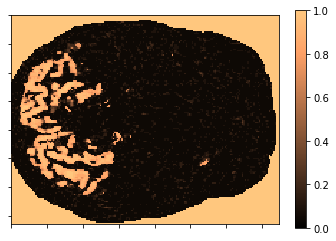

In [10]:
# this example saves output files to the folder  "example1outputs/GLMsingle"
# if these outputs don't already exist, we will perform the time-consuming call to GLMsingle;
# otherwise, we will just load from disk.

start_time = time.time()

if not exists(outputdir_glmsingle):

    print(f'running GLMsingle...')
    
    # run GLMsingle
    results_glmsingle = glmsingle_obj.fit(
       design,
       data,
       stimdur,
       tr,
       outputdir=outputdir_glmsingle)
    
    # we assign outputs of GLMsingle to the "results_glmsingle" variable.
    # note that results_glmsingle['typea'] contains GLM estimates from an ONOFF model,
    # where all images are treated as the same condition. these estimates
    # could be potentially used to find cortical areas that respond to
    # visual stimuli. we want to compare beta weights between conditions
    # therefore we are not going to include the ONOFF betas in any analyses of 
    # voxel reliability
    
else:
    print(f'loading existing GLMsingle outputs from directory:\n\t{outputdir_glmsingle}')
    
    # load existing file outputs if they exist
    results_glmsingle = dict()
    results_glmsingle['typea'] = np.load(join(outputdir_glmsingle,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
    results_glmsingle['typeb'] = np.load(join(outputdir_glmsingle,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
    results_glmsingle['typec'] = np.load(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npy'),allow_pickle=True).item()
    results_glmsingle['typed'] = np.load(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npy'),allow_pickle=True).item()

elapsed_time = time.time() - start_time

print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)

### Summary of important outputs

In [11]:
# the outputs of GLMsingle are formally documented in its
# header. here, we highlight a few of the more important outputs:

# R2 -> is model accuracy expressed in terms of R^2 (percentage).

# betasmd -> is the full set of single-trial beta weights (X x Y x Z x
# TRIALS). beta weights are arranged in chronological order.

# HRFindex -> is the 1-index of the best fit HRF. HRFs can be recovered
# with getcanonicalHRFlibrary(stimdur,tr)

# FRACvalue -> is the fractional ridge regression regularization level
# chosen for each voxel. values closer to 1 mean less regularization.

### Plot a slice of brain showing GLMsingle outputs

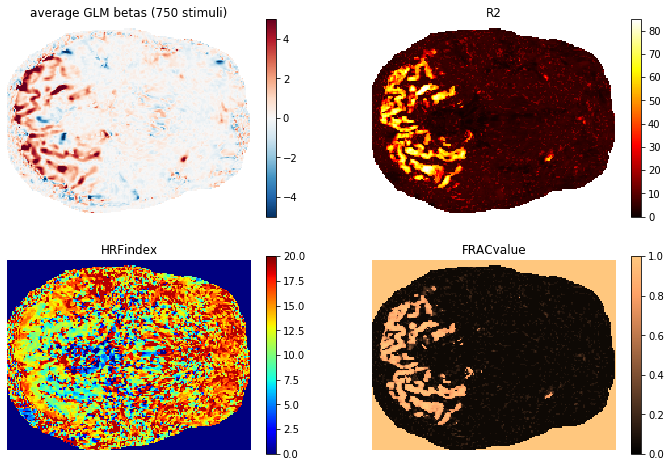

In [12]:
# we are going to plot several outputs from the FIT_HRF_GLMdenoise_RR GLM,
# which contains the full set of GLMsingle optimizations.

# we will plot betas, R2, optimal HRF indices, and the voxel frac values
plot_fields = ['betasmd','R2','HRFindex','FRACvalue']
colormaps = ['RdBu_r','hot','jet','copper']
clims = [[-5,5],[0,85],[0,20],[0,1]]

plt.figure(figsize=(12,8))

for i in range(len(plot_fields)):
    
    plt.subplot(2,2,i+1)
    
    if i == 0:
        # when plotting betas, for simplicity just average across all image presentations
        # this will yield a summary of whether voxels tend to increase or decrease their 
        # activity in response to the experimental stimuli (similar to outputs from 
        # an ONOFF GLM)
        plot_data = np.nanmean(np.squeeze(results_glmsingle['typed'][plot_fields[i]]),2)
        titlestr = 'average GLM betas (750 stimuli)'
    
    else:
        # plot all other voxel-wise metrics as outputted from GLMsingle
        plot_data = np.squeeze(results_glmsingle['typed'][plot_fields[i]].reshape(xyz))
        titlestr = plot_fields[i]
    
    plt.imshow(plot_data,cmap=colormaps[i],clim=clims[i])
    plt.colorbar()
    plt.title(titlestr)
    plt.axis(False)

### Run a baseline GLM to compare with GLMsingle outputs

In [13]:
# for comparison purposes we are going to run a standard GLM
# without HRF fitting, GLMdenoise, or ridge regression regularization. we
# will compute the split-half reliability at each voxel using this baseline
# GLM, and then assess whether reliability improves using the output betas
# from GLMsingle. 

# output directory for baseline GLM
outputdir_baseline = join(outputdir,'GLMbaseline')

# we will run this baseline GLM by changing the default settings in GLMsingle 
# contained within the "opt" structure.
opt = dict() 

# turn off optimizations 
opt['wantlibrary'] = 0 # switch off HRF fitting
opt['wantglmdenoise'] = 0 # switch off GLMdenoise
opt['wantfracridge'] = 0 # switch off ridge regression


# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk...
# the first two indices are the ON-OFF GLM and the baseline single-trial GLM. 
# no need to save the third (+ GLMdenoise) and fourth (+ fracridge) outputs
# since they will not even be computed
opt['wantmemoryoutputs'] = [1,1,0,0] 
opt['wantfileoutputs'] = [1,1,0,0]

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmbaseline_obj = GLM_single(opt)

# visualize the hyperparameters, including the modified baseline opts
pprint(glmbaseline_obj.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1628732438.9772277,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [1, 1, 0, 0],
 'wantfracridge': 0,
 'wantglmdenoise': 0,
 'wantlibrary': 0,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 0, 0],
 'wantparametric': 0,
 'wantpercentbold': 1}


In [14]:
start_time = time.time()

# if these outputs don't already exist, we will perform the call to
# GLMsingle; otherwise, we will just load from disk.
if not exists(outputdir_baseline):
    
    print(f'running GLMsingle...')

    # run GLMsingle, fitting the baseline GLM
    results_assumehrf = glmbaseline_obj.fit(
       design,
       data,
       stimdur,
       tr,
       outputdir=outputdir_baseline)
    
else:
    
    print(f'loading existing GLMsingle outputs from directory:\n\t{outputdir_glmsingle}')
    
    results_assumehrf = dict()
    results_assumehrf['typea'] = np.load(join(outputdir_baseline,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
    results_assumehrf['typeb'] = np.load(join(outputdir_baseline,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
    
    # note that even though we are loading TYPEB_FITHRF betas, HRF fitting
    # has been turned off and this struct field will thus contain the
    # outputs of a GLM fit using the canonical HRF.
    
elapsed_time = time.time() - start_time
print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)

running GLMsingle...
*** FITTING TYPE-A MODEL (ONOFF) ***

fitting model...
done.

preparing output...
done.

computing model fits...
done.

computing R^2...
done.

computing SNR...
done.


*** Saving results to /lab_data/tarrlab/jacobpri/GLMsingle/examples/example1outputs/GLMbaseline/TYPEA_ONOFF.npy. ***



chunks:   0%|          | 0/1 [00:00<?, ?it/s]

*** Setting brain R2 threshold to 1.3429856062725927 ***

*** FITTING TYPE-B MODEL (FITHRF) ***



chunks: 100%|██████████| 1/1 [00:10<00:00, 10.90s/it]



*** Saving results to /lab_data/tarrlab/jacobpri/GLMsingle/examples/example1outputs/GLMbaseline/TYPEB_FITHRF.npy. ***

*** All model types done ***

*** return model types in results ***

	elapsed time:  00:00:18


In [39]:
# create dictionary containing the GLM betas from the four different models we will compare.
# note that the "assume hrf" betas come from the "typeb" field of our baseline GLM
# (with HRF fitting turned off), and that the "fit hrf" betas also come from 
# the "typeb" field of the GLM that ran with all default GLMsingle routines
# enabled

models = dict()
models['assumehrf'] = results_assumehrf['typeb']['betasmd'].reshape(xyz + (750,))
models['fithrf'] = results_glmsingle['typeb']['betasmd']
models['fithrf_glmdenoise'] = results_glmsingle['typec']['betasmd']
models['fithrf_glmdenoise_rr'] = results_glmsingle['typed']['betasmd']

### Get indices of repeated conditions to use for reliability calculations

In [40]:
# to compare the results of different GLMs we are going to calculate the
# voxel-wise split-half reliablity for each model. reliability values
# reflect a correlation between beta weights for repeated presentations of
# the same conditions. in short, we are going to check how
# reliable/reproducible are the single trial responses to repeated
# conditions estimated with each GLM type.

# this NSD scan session has a large number of images that are just shown
# once during the session, some images that are shown twice, and a few that
# are shown three times. in the code below, we are attempting to locate the
# indices in the beta weight GLMsingle outputs modelmd(x,y,z,trials) that
# correspond to repeated images. here we only consider stimuli that have
# been presented at least twice. for the purpose of the example we ignore
# the 3rd repetition of the stimulus.

# consolidate design matrices
designALL = np.concatenate(design,axis=0)

# construct a vector containing 0-indexed condition numbers in chronological order
corder = []
for p in range(designALL.shape[0]):
    if np.any(designALL[p]):
        corder.append(np.argwhere(designALL[p])[0,0])
        
corder = np.array(corder)

In [41]:
# let's take a look at the first few entries
print(corder[:3])

# note that [374 496 7] means that the first stimulus trial involved
# presentation of the 374th condition (zero-indexed), the second stimulus trial 
# involved presentation of the 496th condition, and so on.

[374 496   7]


In [42]:
# in order to compute split-half reliability, we have to do some indexing.
# we want to find images with least two repetitions and then prepare a
# useful matrix of indices that refer to when these occur.

repindices = [] # 2 x images containing stimulus trial indices.

# the first row refers to the first presentation; the second row refers to
# the second presentation.
for p in range(designALL.shape[1]): # loop over every condition
    
    temp = np.argwhere(corder==p)[:,0] # find indices where this condition was shown
    
    # note that for conditions with 3 presentations, we are simply ignoring the third trial
    if len(temp) >= 2:
        repindices.append([temp[0], temp[1]]) 

repindices = np.vstack(np.array(repindices)).T   

In [43]:
# let's take a look at a few entries
print(repindices[:,:3])

# notice that the first condition is presented on the 216th zero-indexed 
# stimulus trial and the 485th stimulus trial, the second condition is presented on the
# 217th and 620st stimulus trials, and so on.

print(f'there are {repindices.shape[1]} repeated conditions in the experiment')

# now, for each voxel we are going to correlate beta weights describing the
# response to images presented for the first time with beta weights
# describing the response from the repetition of the same image. with 136
# repeated conditions, the correlation for each voxel will reflect the
# relationship between two vectors with 136 beta weights each.

[[216 217  18]
 [485 620 123]]
there are 136 repeated conditions in the experiment


### Visualize cortical ROI defining visually-responsive areas

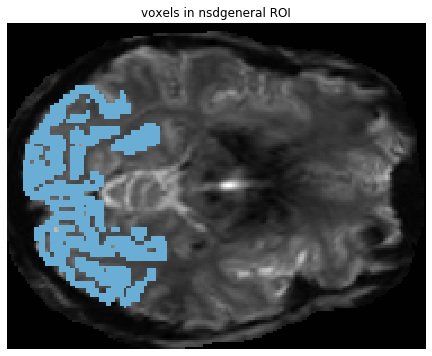

In [44]:
# get mask defining liberal visual cortex ROI. "nsdgeneral" is a general ROI 
# that was manually drawn on fsaverage covering voxels responsive to the NSD experiment 
# in the posterior aspect of cortex. for the sake of simplicity we will focus 
# on voxels within this ROI in computing split-half reliability

nsdgeneral_roi = roi.astype(float)

# convert voxels outside ROI to nan for overlay plotting
nsdgeneral_roi[nsdgeneral_roi==0] = np.nan 

# get mean fMRI volume from run 1
meanvol = np.squeeze(np.mean(data[0].reshape(xyzt),axis=3))

# plot ROI on top of overlay
plt.figure(figsize=(12,6))
plt.imshow(meanvol,cmap='gray')
plt.imshow(nsdgeneral_roi,cmap='Blues',clim=(0,2))

plt.title('voxels in nsdgeneral ROI')
plt.box(False)
plt.axis(False);

### Compute median split-half reliability within the ROI for each beta version

In [45]:
# finally, let's compute split-half reliability. we are going to loop
# through our 4 models and calculate split-half reliability for each of them

vox_reliabilities = [] # output variable for reliability values

modelnames = list(models.keys())

# for each beta version...
for m in range(len(modelnames)):
    
    print(f'computing reliability for beta version: {modelnames[m]}')
    time.sleep(1)
    
    # get the repeated-condition GLM betas using our repindices variable
    betas = models[modelnames[m]][:,:,:,repindices] # automatically reshapes to (X x Y x Z x 2 x nConditions)
    x,y,z = betas.shape[:3] 
    
    rels = np.full((x,y,z),np.nan)
    
    # loop through voxels in the 3D volume...
    for xx in tqdm(range(x)):
        for yy in range(y):
            for zz in range(z):
                
                # reliability at a given voxel is pearson correlation between response profiles from first and 
                # second image presentations (dim = 136 conditions)
                rels[xx,yy,zz] = np.corrcoef(betas[xx,yy,zz,0],
                                             betas[xx,yy,zz,1])[1,0]
          
    vox_reliabilities.append(rels)


computing reliability for beta version: assumehrf


100%|██████████| 145/145 [00:03<00:00, 42.36it/s]


computing reliability for beta version: fithrf


100%|██████████| 145/145 [00:03<00:00, 44.11it/s]


computing reliability for beta version: fithrf_glmdenoise


100%|██████████| 145/145 [00:03<00:00, 44.15it/s]


computing reliability for beta version: fithrf_glmdenoise_rr


100%|██████████| 145/145 [00:03<00:00, 43.92it/s]


### Assess change in reliability yielded by GLMsingle

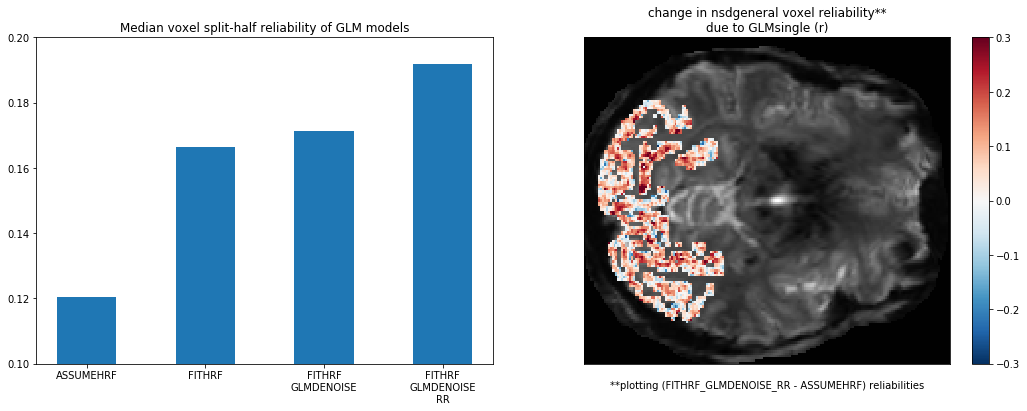

In [47]:
# for each GLM we will calculate median reliability for voxels within the
# nsdgeneral visual ROI and compare using a bar graph

comparison = []
for vr in vox_reliabilities:
    comparison.append(np.nanmedian(vr[nsdgeneral_roi==1]))

plt.figure(figsize=(18,6))
plt.subplot(121)
plt.bar(np.arange(len(comparison)),comparison,width=0.5)
plt.title('Median voxel split-half reliability of GLM models')
plt.xticks(np.arange(4),np.array(['ASSUMEHRF', 'FITHRF', 'FITHRF\nGLMDENOISE', 'FITHRF\nGLMDENOISE\nRR']));
plt.ylim([0.1,0.2])

# draw plot showing the change in reliability between the baseline GLM
# and the final output of GLMsingle (fithrf-glmdenoise-RR betas)
vox_improvement = np.squeeze(vox_reliabilities[3] - vox_reliabilities[0])
vox_improvement[nsdgeneral_roi != 1] = np.nan

plt.subplot(122)
plt.imshow(meanvol,cmap='gray',aspect='auto')
plt.imshow(vox_improvement,cmap='RdBu_r',clim=(-0.3,0.3),aspect='auto')
plt.colorbar()
plt.title('change in nsdgeneral voxel reliability**\ndue to GLMsingle (r)')
plt.xticks([])
plt.yticks([])
plt.xlabel('\n**plotting (FITHRF_GLMDENOISE_RR - ASSUMEHRF) reliabilities');

# notice that there is systematic increase in reliability moving from the
# first to the second to the third to the final fourth version of the GLM
# results. these increases reflect, respectively, the addition of HRF
# fitting, the derivation and use of data-driven nuisance regressors, and
# the use of ridge regression as a way to regularize the instability of
# closely spaced experimental trials. depending on one's experimental
# goals, it is possible with setting of option flags to activate a subset
# of these analysis features.

# also, keep in mind that in the above figure, we are simply showing the
# median as a metric of the central tendency (you may want to peruse
# individual voxels in scatter plots, for example).